## Python imports

In [140]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from math import sqrt
import scikit_posthocs as sp

## Read data for statistical tests

In [146]:
data_samples = dict()
MODEL_DATA_PREFIX = {
    'SoftVoting': 'results/hybrid/SoftVoting',
    'KNN': 'results/hybrid/KNN',
    'LogisticRegression': 'results/hybrid/LogisticRegression',
    'RandomForest': 'results/hybrid/RandomForest',
    'BRSSI': 'results/brssi/RandomForest',
    'CNN': 'results/vision/MobileNetV2'
}
MODELS = list(MODEL_DATA_PREFIX.keys())
DATASETS = ['TS', 'PW', 'RW']
LEN = {'TS': 941, 'PW': 363, 'RW': 446}
#r = []
for d in DATASETS:
    data_samples[d] = dict()
    bdf_defined = False
    for m in MODELS:
        df = pd.read_csv(MODEL_DATA_PREFIX[m] + '_' + d + '.tsv', sep='\t')
        if bdf_defined == False:
            bdf = df
            bdf_defined = True
        samples = (df['label'] == df['prediction']).astype(float)[:LEN[d]]
        print(d,m,len(samples),samples.mean())
        data_samples[d][m] = samples

TS SoftVoting 941 0.9766206163655685
TS KNN 941 0.9766206163655685
TS LogisticRegression 941 0.9776833156216791
TS RandomForest 941 0.9617428267800212
TS BRSSI 941 0.9202975557917109
TS CNN 941 0.8618490967056323
PW SoftVoting 363 0.8181818181818182
PW KNN 363 0.8539944903581267
PW LogisticRegression 363 0.859504132231405
PW RandomForest 363 0.8402203856749312
PW BRSSI 363 0.8484848484848485
PW CNN 363 0.5674931129476584
RW SoftVoting 446 0.9125560538116592
RW KNN 446 0.9013452914798207
RW LogisticRegression 446 0.9080717488789237
RW RandomForest 446 0.8609865470852018
RW BRSSI 446 0.8183856502242153
RW CNN 446 0.6883408071748879


## Friedman test

In [147]:
avg_acc = pd.DataFrame({
    ds: [np.mean(data_samples[ds][m]) for m in MODELS]
    for ds in data_samples
}, index=MODELS).T
print(avg_acc)
stat, p_omnibus = friedmanchisquare(*(avg_acc[m] for m in MODELS))
print(f"Friedman test statistic = {stat:.3f}, p = {p_omnibus:.5f}")

    SoftVoting       KNN  LogisticRegression  RandomForest     BRSSI       CNN
TS    0.976621  0.976621            0.977683      0.961743  0.920298  0.861849
PW    0.818182  0.853994            0.859504      0.840220  0.848485  0.567493
RW    0.912556  0.901345            0.908072      0.860987  0.818386  0.688341
Friedman test statistic = 11.538, p = 0.04169


## Post-hoc Wilcoxon tests on per-sample accuracies


Post-hoc pairwise comparisons (raw p-values):
                             Comparison  Wilcoxon W         p-raw  Reject H0
0                    SoftVoting vs KNN      1100.5  3.389798e-01      False
1     SoftVoting vs LogisticRegression       756.0  7.540356e-02      False
2           SoftVoting vs RandomForest      2296.0  5.913164e-03       True
3                  SoftVoting vs BRSSI     13531.5  4.704578e-07       True
4                    SoftVoting vs CNN     20944.0  7.807004e-43       True
5            KNN vs LogisticRegression        57.0  1.572992e-01      False
6                  KNN vs RandomForest      1632.0  2.317407e-04       True
7                         KNN vs BRSSI     12059.5  2.156643e-08       True
8                           KNN vs CNN     20640.0  1.062829e-44       True
9   LogisticRegression vs RandomForest      1400.0  1.548579e-05       True
10         LogisticRegression vs BRSSI     11214.0  1.869413e-09       True
11           LogisticRegression vs CNN  

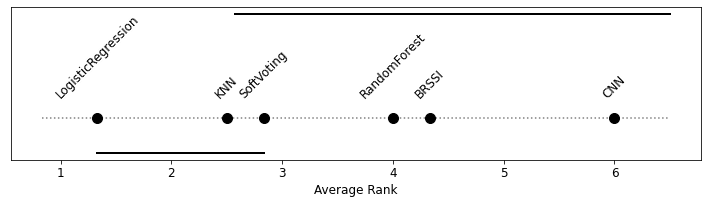

In [162]:
results = []
comparisons = []
for i in range(len(MODELS)):
    for j in range(i+1, len(MODELS)):
        acc1 = np.concatenate([data_samples[ds][MODELS[i]] for ds in data_samples])
        acc2 = np.concatenate([data_samples[ds][MODELS[j]] for ds in data_samples])
        #print(i,j,len(acc1),len(acc2))
        try:
            stat_w, p = wilcoxon(acc1, acc2)
        except ValueError:
            stat_w, p = np.nan, 1.0
        reject = p < 0.05
        results.append({
            "Comparison": f"{MODELS[i]} vs {MODELS[j]}",
            "Wilcoxon W": stat_w,
            "p-raw": p,
            "Reject H0": reject
        })
        comparisons.append(((MODELS[i], MODELS[j]), reject))

results_df = pd.DataFrame(results)
print("\nPost-hoc pairwise comparisons (raw p-values):\n", results_df)

# -------------------------
# 4. Critical Difference Diagram
# -------------------------
ranks = avg_acc.rank(axis=1, ascending=False)
avg_ranks = ranks.mean().sort_values()

# Build clusters: models not significantly different
nonsig_pairs = [pair for pair, reject in comparisons if not reject]
clusters = []
for model in avg_ranks.index:
    placed = False
    for cluster in clusters:
        if any(((model, m) in nonsig_pairs or (m, model) in nonsig_pairs) for m in cluster):
            cluster.add(model)
            placed = True
            break
    if not placed:
        clusters.append(set([model]))


font = {'family' : 'normal', 'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(10, 3))
y = 1
plt.scatter(avg_ranks, [y]*len(avg_ranks), s=100, zorder=3, color='black')
for model, x in avg_ranks.items():
    plt.text(x, y+0.05, model, ha="center", va="bottom", rotation=45)

plt.hlines(y, min(avg_ranks)-0.5, max(avg_ranks)+0.5, colors="gray", linestyles="dotted")

# Draw clusters
cluster_y = y - 0.1
for cluster in clusters:
    print(cluster)
    if len(cluster) > 1:
        x1 = min(avg_ranks[list(cluster)])
        x2 = max(avg_ranks[list(cluster)])
        plt.plot([x1, x2], [cluster_y, cluster_y], color="black", lw=2)
        cluster_y -= 0.1

# -------------------------
# 5. Compute Critical Difference bar (configurable alpha)
# -------------------------
alpha = 0.05  # change to 0.01 or 0.10 if desired
k = len(models)
N = len(data_samples)

# Use scikit-posthocs Nemenyi for CD calculation
nemenyi = sp.posthoc_nemenyi_friedman(avg_acc.values)

# For now, we fallback to standard q_alpha approximations
if alpha == 0.05:
    q_alpha_val = 2.569
elif alpha == 0.10:
    q_alpha_val = 2.291
elif alpha == 0.01:
    q_alpha_val = 3.113
else:
    q_alpha_val = 2.569  # default to 0.05 table value

CD = q_alpha_val * sqrt(k * (k+1) / (6.0 * N))

x_start = max(avg_ranks) + 0.5
plt.plot([x_start, x_start - CD], [y+0.3, y+0.3], color="black", lw=2)
#plt.text(x_start - CD/2, y+0.35, f"CD = {CD:.2f} (alpha={alpha})", ha="center", va="bottom")

#plt.title("Critical Difference Diagram (sample-level, configurable alpha)")
plt.xlabel("Average Rank")
plt.yticks([])
#plt.show()
plt.tight_layout()
plt.savefig('hm_statistical_analysis.pdf')